In [176]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)

df_train = pd.read_csv("../data/preprocessed/df_train001.csv")
df = pd.read_csv("../data/preprocessed/df.csv")

---

In [177]:
df_train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,11.933,48.699342,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,11.933,48.699342,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,11.933,48.699342,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,11.933,48.699342,7.5
4,1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,11.933,48.699342,-4.6


In [178]:
df_train['년'] = np.float64(df_train['일시'].str.split('-', expand=True)[0])
df_train['월'] = np.float64(df_train['일시'].str.split('-', expand=True)[1])
df_train['일'] = np.float64(df_train['일시'].str.split('-', expand=True)[2])

In [179]:
df['년'] = np.float64(df['일시'].str.split('-', expand=True)[0])
df['월'] = np.float64(df['일시'].str.split('-', expand=True)[1])
df['일'] = np.float64(df['일시'].str.split('-', expand=True)[2])

In [180]:
from sklearn.preprocessing import StandardScaler

In [181]:
scaler = StandardScaler()

In [182]:
X = df_train.drop(columns=['일시','평균기온'], axis=1)
y = df_train['평균기온']

In [183]:
X = scaler.fit_transform(X)

In [184]:
from sklearn.model_selection import train_test_split

In [185]:
x_train, x_test, y_train , y_test = train_test_split(X, y, test_size = 0.5, random_state=42 )

---

In [186]:
import tensorflow as tf

In [187]:
# 데이터를 3D로 변환
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

In [188]:
x_train.shape

(11505, 12, 1)

In [192]:
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=64, return_sequences=True, input_shape=(12, 1)),
    tf.keras.layers.GRU(units=64, return_sequences=True, input_shape=(12, 1)),# 수정된 input_shape
    tf.keras.layers.Dense(1)
])

In [193]:
# 모델 컴파일
model.compile(optimizer='Nadam', loss='huber')

In [194]:
# 모델 학습
model.fit(x_train, y_train.values, epochs=10, batch_size=32)

Epoch 1/10
360/360 [==============================] - 6s 8ms/step - loss: 9.1203
Epoch 2/10
360/360 [==============================] - 3s 9ms/step - loss: 8.5858
Epoch 3/10
360/360 [==============================] - 3s 9ms/step - loss: 8.5651
Epoch 4/10
360/360 [==============================] - 3s 9ms/step - loss: 8.5630
Epoch 5/10
360/360 [==============================] - 3s 8ms/step - loss: 8.5620
Epoch 6/10
360/360 [==============================] - 3s 8ms/step - loss: 8.5593
Epoch 7/10
360/360 [==============================] - 3s 9ms/step - loss: 8.5605
Epoch 8/10
360/360 [==============================] - 4s 10ms/step - loss: 8.5585
Epoch 9/10
360/360 [==============================] - 4s 10ms/step - loss: 8.5581
Epoch 10/10
360/360 [==============================] - 4s 10ms/step - loss: 8.5615


---

In [195]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [196]:
df_x = scaler.transform(df.drop(columns=['일시'], axis=1))

In [198]:
# 데이터를 3D로 변환
df_x = df_x.reshape((df_x.shape[0], df_x.shape[1], 1))

In [201]:
df_x.shape

(358, 12, 1)

In [209]:
sub_file['평균기온'] = model.predict(df_x).mean(axis=1)

12/12 [==============================] - 0s 3ms/step


<AxesSubplot:>

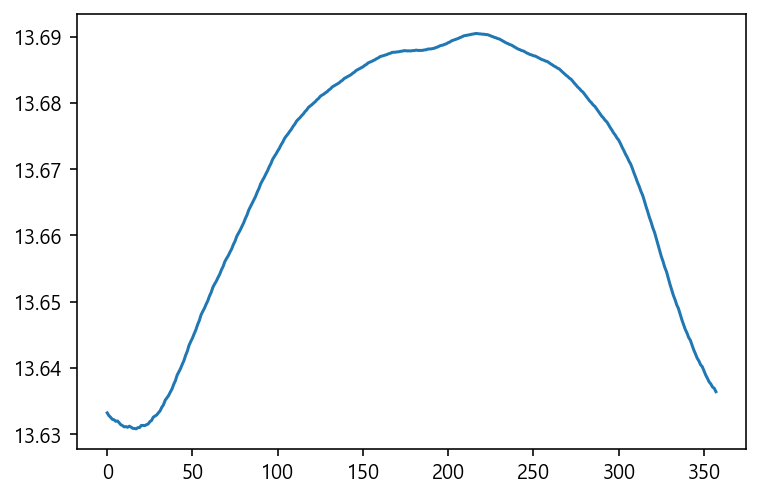

In [210]:
sub_file['평균기온'].plot()

In [211]:
sub_file.to_csv("../data/sub/037_df_GRU_001.csv",
                index=False, encoding='utf-8')

---

In [212]:
import joblib

In [213]:
joblib.dump(model, '../model/GRU_001.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\gru
......vars
...layers\gru\cell
......vars
.........0
.........1
.........2
...layers\gru_1
......vars
...layers\gru_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-12-25 21:11:10         2654
metadata.json                                  2023-12-25 21:11:10           64
variables.h5                                   2023-12-25 21:11:10       480976


['../model/GRU_001.pkl']

In [214]:
loaded_model = joblib.load('../model/GRU_001.pkl')

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-12-25 21:11:10         2654
metadata.json                                  2023-12-25 21:11:10           64
variables.h5                                   2023-12-25 21:11:10       480976
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\gru
......vars
...layers\gru\cell
......vars
.........0
.........1
.........2
...layers\gru_1
......vars
...layers\gru_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
